## Examples

Why is clustering useful?
- for data analysis - when you analyze a new dataset it can be usfelu running a clustering algorithm and then analysing each cluster separately
- dimensionality reduction - when you have k clusters you can replace an instance x with the vector of its cluster affinities. This will wiled a lower k-dimensional vector
- Segmenting an image - if we cluster the data according to their color and then replace each instance color with the respective mean cluster color, it is possible to reduce the overall number of colors in an image, making it easier to analyze. Note that this is just another dimensionality reduction task.  

#### k-means
This one here is the easiest yet powerful clustering algorithm. It is a parametric one, since it assumes the clusters in the data to have a spherical shape. 

**Note** Scaling feature beforehand generally improves the algorithm performance.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

x,y = make_blobs(n_samples=500, random_state=42, centers=5)

k = 5 # the algorithm will detect five clusters
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X=x)

In [ ]:
# data visualization
from matplotlib.pyplot import scatter
scatter(x[:,0], x[:,1])

In [ ]:
# predictions
kmeans.labels_

In [ ]:
# overall result
import matplotlib.pyplot as plt
def plotting_clusters(alg, x):
    # data 
    plt.plot(x[:,0], x[:,1], "y^", label = "data")
    # centroid coordinates
    centers = alg.cluster_centers_
    i = 0
    for c in centers:
        plt.plot(c[0], c[1], "bs", label = f"centroid {i}")
        i += 1
    plt.legend(loc="lower right", fontsize=8)
plotting_clusters(kmeans, x)
# plt.savefig("k means cluster")

In [ ]:
# prediction making
X_new, y_new = make_blobs(20, random_state=42, centers= 5)
kmeans.predict(X_new)
plotting_clusters(kmeans, X_new)

In general k-means is an algorithm used to perform hard-clustering, meaning that each instace is assignes only to one cluster per time. In some cases it might be useful to be a little more conservative, performing soft-sclutering. In this case the algorithm will output a score (often a probability) for each point to belong to a cluster. In k-means it is reasonable thinking that such a score coud be the distance of each point to the centroids.

In [ ]:
kmeans.transform(X_new)

In general k-means algorithm places the centrois in a random way choosing k instances among the data at random. If you already have a sense about where the centroids should be placed at the beginning, you can tell their coordinates. 

In order to avoid doing this, in sklearn the centroid placing method used is the K-means++ by default. The goal is finding an efficient way of spreading the centroids the most. Here's how it works:
1. select the first centroid at random within the training instances
2. assign to each pint in the dataset a probility measure proportional to the distance squared from the closest centroid
3. draw a new centroid accoringly to the probabilities assigned to the data

In [ ]:
# setting manually the centroids
start = ([[-3,3], [-3,2], [-3,1], [-1,2], [0,2]])
kmeans_new = KMeans(n_clusters=5, init=start)

Finally we need to address the last two important things:
- assessing model performance - this can be done by using as performance measure the sum over all datapoints of the squared distance from the respective centroid
- controoling the number of runs performed - kmeans strongly depedns from the initial centroids position. Since we place them casually different runs of the algorithm will yield different results. By default sklearn runs the algorithm 10 times and outputs the best clustering results, based upon the above performance measure

In [ ]:
# performance measure: inertia
kmeans.inertia_
# score: - inertia (every score in sklearn is interpreted by the rule "greater is better")
kmeans.score(x)

In [ ]:
# setting the number of iterations to be performed
kmeans_new = KMeans(n_clusters=4, n_init=6)

##### Finding the optimal number of clusters

The number of clusters k in k-means in the only hyperparameter to set. It impacts a lot the model performance, so it pretty important getting if right. The best idea is using some performance measures, like the inertia.

Using inertia we could make a plot of model inertia wrt to the number of clusters. Then we look for the elbow in the plot. 

In [ ]:
# dgp
x,y = make_blobs(n_samples=500, random_state=42, centers=5)

In [ ]:
# model creation and training
kmeans = KMeans(n_clusters=5, random_state= 42)
kmeans.fit(x)

In [ ]:
from numpy import arange
from matplotlib import pyplot as plt

k_val = arange(1,10)
performance = []

for k in k_val: 
    k = int(k)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    performance.append(kmeans.inertia_)

plt.plot(k_val, performance,"o-r")
plt.xlabel("k")
plt.ylabel("inertia")
# plt.savefig("elbow")

Another important performance measure for clustering is the silhoutte coefficient. 

In [ ]:
from sklearn.metrics import silhouette_score
from numpy import arange
from matplotlib import pyplot as plt

k_val = arange(2,10)
performance = []

for k in k_val: 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    labels = kmeans.labels_
    performance.append(silhouette_score(x, labels))

plt.plot(k_val, performance,"o-b")
plt.xlabel("k")
plt.ylabel("silhoutte score")
plt.savefig("silhoutte_score")

The silhoutte coefficient give more information then the inertia score. So better be using it.

##### k-means application

- preprocessing the data (dimensionality reduction) 

We cluster the data in k different clusters, then we substitute an instance features with cluster similarity for each cluaster we have found. This wai we'll reduce the training instances to be k-dimensional.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_digits # 8x8 pixel instances, 64 features
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
X, y = load_digits(return_X_y=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# before using clustering for preprocessing the data
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

In [ ]:
# using clustering for preprocessing the data
model = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=50)), # instances now have 50 features, one for each culster similarity score 
    ("log_reg", LogisticRegression(max_iter=3000))
])

model.fit(X_train, y_train)
model.score(X_test, y_test)

Another important feature of using clustering for data preprocesing is that the number of clusters k is just another hyperparameter of the overall model. So we can find the best value for it by GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2,100))
grid_clf = GridSearchCV(model, param_grid=param_grid, cv =3)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

#### DBSCAN and HBDSCAN

This clustering algorithm can be seen as the non-parametric counterpart of k-means. It doesn't make any assumptions beforehand about the clusters form. Yet it is more difficult to tune, the value of $\epsilon$ is very nasty to get right

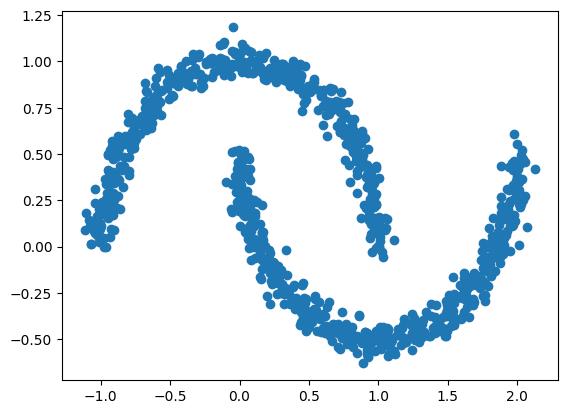

In [194]:
from sklearn.datasets import make_moons
from matplotlib.pyplot import scatter

X, y = make_moons(n_samples=1000, noise = 0.05)
scatter(X[:,0], X[:,1])

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.05, min_samples=5)
dbscan.fit(X)
dbscan.labels_  # note that this algorithm finds 7 different clusters, not a good job
# label = -1 when the point has been labelles as noise and thus dropped

array([ 0,  1,  2,  4,  0,  0,  3,  3,  3,  0,  0,  3,  3,  3,  0,  0,  3,
        4,  2,  4,  0,  2,  3,  5,  0,  0,  6,  6,  3,  3,  4, -1,  2,  0,
        3, -1,  0,  4,  0,  5,  3,  3,  0,  3,  6,  2,  5,  7,  6,  0,  1,
        3,  7,  1,  3,  3,  0,  6,  2,  3,  0,  3,  5,  3,  7,  1,  3, -1,
        3,  2,  0,  3,  2, -1,  0,  6,  3,  0,  2,  5,  0,  3,  6,  0,  3,
        0,  3,  0,  3,  0,  3, -1,  6,  4,  3,  4,  2,  0,  3, -1, -1,  3,
        2,  1,  0,  0,  0,  3,  6, -1,  3,  3,  7,  3,  6,  3,  3,  6,  3,
       -1,  0, -1,  3,  2,  6,  3, -1,  0,  0,  3,  7,  0,  1,  3, -1,  3,
        2,  2,  3,  6,  0,  3,  3,  3,  2,  5,  3,  0,  2,  4,  6,  2,  3,
        3,  6,  3,  0,  2,  2,  0,  0,  3, -1,  3,  6,  2, -1,  0, -1,  6,
        3,  5,  0,  3,  3,  6,  7, -1,  6,  6,  3,  0,  0,  0,  3,  3,  0,
        0,  0,  3,  6,  4,  2, -1,  3,  3,  3,  0,  3,  6, -1,  7,  3,  5,
        2,  6,  2,  3,  6,  1,  1,  5,  4,  3,  3,  0,  4,  3, -1,  3,  1,
        0,  0,  4,  3,  3

If we want to avoid the burden of chosing $\epsilon$ we may try ti use the HDSCAN algorithm. That is a non-parametric, hierarchical clustering algorithm (see notes for more). It has only one hyperparameter, that is the minimum number of instances that must be found in a cluster to be one. 

In [ ]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=5) # default: n_samples = 5
hdbscan.fit(X)
hdbscan.labels_ # 2 clusters are correctly found, labels = {0,1}

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,

This last algorithm is very powerfu and easy to use. A reccomandation is using it as work-horse. It is very flexible and pretti efficient, so you can alway use this one without worrying too much at a first approach with the data 

#### Gaussian Mixtures

Yet another parametric clustering algorithm. The difference here is that the clustering is performed following a soft approach, meaning that we ooutput a probability of each instance to belong to a certain cluster. 

The parametric assumption we make is that the data were drawm from a sum of multivariate gaussian distributions. The algorithm, loogking at the data, tries finding the parameters of each one of this mvn distributions. 

The number of mvn to consider is the only hyperparameter of this algorithm. 

In [ ]:
# dgp
from sklearn.datasets import make_moons
from matplotlib.pyplot import scatter

X, y = make_moons(n_samples=1000, noise = 0.05)

In [199]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, n_init = 10)
gm.fit(X)

GaussianMixture(n_components=2, n_init=10)

In [200]:
# parameters estimated
print(f"weights: {gm.weights_},means: {gm.means_},covarancies: {gm.covariances_}")

weights: [0.50713041 0.49286959],means: [[-0.12379403  0.62798637]
 [ 1.14235177 -0.14095966]],covarancies: [[[0.3527293  0.04938811]
  [0.04938811 0.09976111]]

 [[0.34458603 0.0547688 ]
  [0.0547688  0.09600087]]]


The parameter weights is an estimate of how important every mvn estimated is, meaning how many samples were most likely drawn from it: the higher, the more sampes were drawm from that distrbution (likely)

In [202]:
# checking convergence 
gm.converged_

True

In [201]:
# checking number of iterations needed for converging
gm.n_iter_

5

In [206]:
# predictions: instances are assigned to the most likely cluster, highest probability computed
gm.predict(X)
# soft predictions: probs for every instance of being drawn from one of the mvn
gm.predict_proba(X) 
# local probability density estimation 
# for each point given, this method uses the computed mvn distribution to output the approximate log pdf 
# value in that point
gm.score_samples(X)[0]

np.float64(-1.507547442039413)

We can also limit the number of shapes the clusters we find. This will help the algorithm, decreasing the total number of parameters it needs to find in order to converge.

The possible shapes you can set is:
- "spherical": for spherical clusters
- "diag": for ellipsoid clusters
- "tied": for ellipsoid cluster of the same size

By default the algorithm will look for clusters of any shape and size.

In [ ]:
gm = GaussianMixture(n_components=2, covariance_type="spherical")

For assessing the performance of a gm model we can use penalized theoretical information criterion:
- BIC (favoring less complex models)
- AIC

The higher they are, the worse the model is. 

In [ ]:
gm.bic(X)
gm.aic(X)

Thus, they can be used for finding the best overall GMM, looking at what combination of hyperparameters yields the lowest value.

## Exercises